In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette(['#1E1E1E', '#BB3524', '#F5D54A', '#384827', '#282F44'])
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': False, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

pd.set_option("display.max_columns", 200)

In [2]:
import itertools

In [3]:
cell_line = 'K562'
bin_size = 1000
datasets = ['feature_accessibility', 'protein', 'feature_histone']

In [4]:
input_matrices = [
    f'../../output/final/bedstats/genomic-window-matrix-{bin_size}bp_bed.{cell_line}.{dataset}.tsv.gz' for dataset in datasets
]

input_chromatin_state_matrix = f'../../output/final/bedstats/genomic-window-matrix-{bin_size}bp_bed.{cell_line}.chromatin_state.tsv.gz' 

input_universe_bed = f'../../output/final/genome/windows.1000bp.noblacklist.bed.gz'

param_chunk_size = 100_000
param_min_periods = 500
param_pseudocount = 100

In [5]:
# Not needed by `compute_matrix_statistics, but useful`
input_peaklists = [
    f'../../output/final/encode/encode_{dataset}_data.{cell_line}.bed.tsv.gz' for dataset in datasets
]

peaklist = []
for file_ in input_peaklists:
    peaklist.append(pd.read_csv(file_, sep='\t', index_col=0))
peaklist = pd.concat(peaklist)

In [6]:
%load_ext autoreload
%aimport compute_matrix_statistics
%autoreload 1

Before we proceed do some basic tests on the `compute_matrix_statistics` script

In [84]:
from numpy.testing import assert_array_equal, assert_array_almost_equal
from scipy.stats import hmean
# Some basic tests

test_matrix_binary = pd.DataFrame([
    [True, True, False], 
    [True, False, False], 
    [True, True, False]], columns=['a', 'b', 'c']
)

test_universe_size = 15
store_test = {}


# marginal probs:
compute_matrix_statistics.do_marginal_counts(
    test_matrix_binary, test_universe_size, store=store_test, pseudocount=2, analysis_mode='test'
)

assert_array_equal(store_test[f'/test/counts/marginal/True'], [3,2,0])
assert_array_equal(store_test[f'/test/counts/marginal/False'], [12, 13, 15])

p_a = (3+2*2) / (15+4*2)
p_b = (2+2*2) / (15+4*2)
p_c = (0+2*2) / (15+4*2)

assert_array_almost_equal(store_test[f'/test/probabilities/marginal/True'], [p_a, p_b, p_c])
assert_array_almost_equal(store_test[f'/test/probabilities/marginal/False'], [1-p_a, 1-p_b, 1-p_c])


# Joint probs:
compute_matrix_statistics.do_joint_counts(
    test_matrix_binary.astype(float), test_universe_size, store=store_test, pseudocount=2, analysis_mode='test'
)

assert_array_equal(
    store_test[f'/test/counts/joint/a:True_b:True'], 
    [
        [np.nan, 2, 0], 
        [2, np.nan, 0], 
        [0, 0, np.nan]
    ]
)


assert_array_almost_equal(
    store_test[f'/test/probabilities/joint/a:True_b:True'], 
    (np.array([
        [np.nan, 2, 0], 
        [2, np.nan, 0], 
        [0, 0, np.nan]
    ]) + 2) / (15+8)
)

# The matrix is triangular here by accident (due to the way `test_matrix_binary` is)
assert_array_equal(
    store_test[f'/test/counts/joint/a:False_b:True'], 
    [
        [np.nan, 0, 0], 
        [1, np.nan, 0], 
        [3, 2, np.nan]
    ]
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/joint/a:False_b:True'], 
    (np.array([
        [np.nan, 0, 0], 
        [1, np.nan, 0], 
        [3, 2, np.nan]
    ]) + 2) / (15+8)
)

assert_array_equal(
    store_test[f'/test/counts/joint/a:True_b:False'], 
    [
        [np.nan, 1, 3], 
        [0, np.nan, 2], 
        [0, 0, np.nan]
    ]
)


assert_array_almost_equal(
    store_test[f'/test/probabilities/joint/a:True_b:False'], 
    ( np.array([
        [np.nan, 1, 3], 
        [0, np.nan, 2], 
        [0, 0, np.nan]
    ]) + 2 ) / (15+8)
)


# Counts here are number of times `test_matrix_binary` is false in column i and j
# plus 12 (universe_size - 3)
assert_array_equal(
    store_test[f'/test/counts/joint/a:False_b:False'], 
    np.array([
        [np.nan, 12, 12], 
        [12, np.nan, 13], 
        [12, 13, np.nan]
    ])
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/joint/a:False_b:False'], 
    (np.array([
        [np.nan, 12, 12], 
        [12, np.nan, 13], 
        [12, 13, np.nan]
    ]) + 2) / (15+8)
)


# Conditional probs
compute_matrix_statistics.do_conditional_probabilities(
    store=store_test, analysis_mode='test'
)


test_matrix_binary = pd.DataFrame([
    [True, True, False], 
    [True, False, False], 
    [True, True, False]], columns=['a', 'b', 'c']
)

# probability column a is true, given column b is true
# (prob a=true, b=true) / (prob b=True)

assert_array_almost_equal(
    store_test[f'/test/probabilities/conditional/a:True_given_b:True'], 
    np.array([
        [np.nan,                 ((2+2)/(15+8)) / (p_b),  ((0+2)/(15+8)) / (p_c)], 
        [((2+2)/(15+8)) / (p_a), np.nan,                  ((0+2)/(15+8)) / (p_c)], 
        [((0+2)/(15+8)) / (p_a), ((0+2)/(15+8)) / (p_b),  np.nan]
    ])
)

# probability column a is false given b is true
assert_array_almost_equal(
    store_test[f'/test/probabilities/conditional/a:False_given_b:True'], 
    np.array([
        [np.nan,                 ((0+2)/(15+8)) / (p_b), ((0+2)/(15+8)) / (p_c)], 
        [((1+2)/(15+8)) / (p_a), np.nan,                 ((0+2)/(15+8)) / (p_c)], 
        [((3+2)/(15+8)) / (p_a), ((2+2)/(15+8)) / (p_b), np.nan]
    ])
)

# Probability a is true given b is false
assert_array_almost_equal(
    store_test[f'/test/probabilities/conditional/a:True_given_b:False'], 
    np.array([
        [np.nan,                   ((1+2)/(15+8)) / (1-p_b), ((3+2)/(15+8)) / (1-p_c)], 
        [((0+2)/(15+8)) / (1-p_a), np.nan,                   ((2+2)/(15+8)) / (1-p_c)], 
        [((0+2)/(15+8)) / (1-p_a), ((0+2)/(15+8)) / (1-p_b), np.nan]
    ])
)

# Probability a is false given b is false

assert_array_almost_equal(
    store_test[f'/test/probabilities/conditional/a:False_given_b:False'], 
    np.array([
        [np.nan,                    ((12+2)/(15+8)) / (1-p_b), ((12+2)/(15+8)) / (1-p_c)], 
        [((12+2)/(15+8)) / (1-p_a), np.nan,                    ((13+2)/(15+8)) / (1-p_c)], 
        [((12+2)/(15+8)) / (1-p_a), ((13+2)/(15+8)) / (1-p_b), np.nan]
    ])
)


# Check that marginalised joint probabilities are equal to marginals
assert_array_almost_equal(
    store_test[f'/test/probabilities/marginal/True'],
    # Mean is taken below because the matrix returned should have identical entries in rows
    sum(store_test[f'/test/probabilities/joint/a:True_b:{b}'] for b in [False, True]).mean(axis=1),
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/marginal/False'],
    # Mean is taken below because the matrix returned should have identical entries in rows
    sum(store_test[f'/test/probabilities/joint/a:False_b:{b}'] for b in [False, True]).mean(axis=1),
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/marginal/True'],
    # Mean is taken below because the matrix returned should have identical entries in cols
    sum(store_test[f'/test/probabilities/joint/a:{b}_b:True'] for b in [False, True]).mean(axis=0),
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/marginal/False'],
    # Mean is taken below because the matrix returned should have identical entries in cols
    sum(store_test[f'/test/probabilities/joint/a:{b}_b:False'] for b in [False, True]).mean(axis=0),
)


# Joint probs, assuming independence
compute_matrix_statistics.do_joint_probabilities_assuming_independence(
    store=store_test, analysis_mode='test'
)

test_matrix_binary = pd.DataFrame([
    [True, True, False], 
    [True, False, False], 
    [True, True, False]], columns=['a', 'b', 'c']
)
assert_array_almost_equal(
    store_test[f'/test/probabilities/joint_independent/a:True_b:True'], 
    np.array([
        [np.nan, p_a*p_b, p_a*p_c],
        [p_b*p_a, np.nan, p_b*p_c], 
        [p_c*p_a, p_c*p_b, np.nan]
    ])
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/joint_independent/a:False_b:True'], 
    np.array([
        [np.nan, (1-p_a)*p_b, (1-p_a)*p_c],
        [(1-p_b)*p_a, np.nan, (1-p_b)*p_c], 
        [(1-p_c)*p_a, (1-p_c)*p_b, np.nan]
    ])
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/joint_independent/a:True_b:False'], 
     np.array([
        [np.nan, p_a*(1-p_b), p_a*(1-p_c)],
        [p_b*(1-p_a), np.nan, p_b*(1-p_c)], 
        [p_c*(1-p_a), p_c*(1-p_b), np.nan]
    ])
)

assert_array_almost_equal(
    store_test[f'/test/probabilities/joint_independent/a:False_b:False'], 
     np.array([
        [np.nan, (1-p_a)*(1-p_b), (1-p_a)*(1-p_c)],
        [(1-p_b)*(1-p_a), np.nan, (1-p_b)*(1-p_c)], 
        [(1-p_c)*(1-p_a), (1-p_c)*(1-p_b), np.nan]
    ])
)


#Entropy
compute_matrix_statistics.do_entropy(store_test, analysis_mode='test')

assert_array_almost_equal(
    store_test[f'/test/entropy/marginal'],
    sum(-store_test[f'/test/probabilities/marginal/{b}'] * np.log(store_test[f'/test/probabilities/marginal/{b}']) for b in [False, True])
)

assert_array_almost_equal(
    store_test[f'/test/entropy/joint'],
    sum(-store_test[f'/test/probabilities/joint/a:{b_a}_b:{b_b}'] * np.log(store_test[f'/test/probabilities/joint/a:{b_a}_b:{b_b}']) for b_a, b_b in itertools.product([False, True], repeat=2))
)

# # MI 
compute_matrix_statistics.do_mutual_information(store_test, analysis_mode='test')

for b_a, b_b in itertools.product([False, True], repeat=2):
    print(f"Checking '/test/mutual_information/elementwise/a:{b_a}_b:{b_b}'")
    assert_array_almost_equal(
        store_test[f'/test/mutual_information/elementwise/a:{b_a}_b:{b_b}'],

        store_test[f'/test/probabilities/joint/a:{b_a}_b:{b_b}'] * (store_test[f'/test/probabilities/joint/a:{b_a}_b:{b_b}'].apply(np.log) - store_test[f'/test/probabilities/joint_independent/a:{b_a}_b:{b_b}'].apply(np.log))
    )
    print("OK")


assert_array_almost_equal(
    store_test[f'/test/mutual_information'],
    store_test[f'/test/mutual_information/elementwise/a:False_b:False'] + store_test[f'/test/mutual_information/elementwise/a:False_b:True'] + store_test[f'/test/mutual_information/elementwise/a:True_b:False'] + store_test[f'/test/mutual_information/elementwise/a:True_b:True'],
)


# Alternative way to implement MI
assert_array_almost_equal(
    (np.broadcast_to(store_test['/test/entropy/marginal'], store_test[f'/test/entropy/joint'].shape).T + np.broadcast_to(store_test['/test/entropy/marginal'], store_test[f'/test/entropy/joint'].shape)) - store_test['/test/entropy/joint'],
    store_test[f'/test/mutual_information']
)

# Normalised MI
compute_matrix_statistics.do_normalised_mutual_information(store_test, analysis_mode='test')

assert_array_almost_equal(
    store_test['/test/uncertainty_coefficient/by_rows'],
    store_test['/test/mutual_information'].divide(store_test['/test/entropy/marginal'], axis=0)
)

assert_array_almost_equal(
    store_test['/test/uncertainty_coefficient/by_cols'],
    store_test['/test/mutual_information'].divide(store_test['/test/entropy/marginal'], axis=1)
)

_uc_avg = hmean([
    store_test['/test/uncertainty_coefficient/by_rows'].fillna(1), 
    store_test['/test/uncertainty_coefficient/by_cols'].fillna(1)
], axis=0)

for i in np.arange(len(_uc_avg)):
    _uc_avg[i,i] = np.nan
    
assert_array_almost_equal(
    store_test['/test/uncertainty_coefficient/avg'],
    _uc_avg
)


print("Everything's OK")

2021-12-16T15:08:48.583481: Computing marginal counts and probabilities.
2021-12-16T15:08:48.584482: Computing marginal counts and probabilities finished. Probability sums (should be == 1):
count    3.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64
2021-12-16T15:08:48.587556: Computing joint counts and probabilities.
2021-12-16T15:08:48.593502: Computing joint counts and probabilities finished. Sums (should be == 1):
count    6.000000e+00
mean     9.999999e-01
std      3.769729e-08
min      9.999999e-01
25%      9.999999e-01
50%      9.999999e-01
75%      1.000000e+00
max      1.000000e+00
dtype: float64
2021-12-16T15:08:48.597587: Computing conditional probabilities.
2021-12-16T15:08:48.603376: Computing joint probabilities assuming independence.
2021-12-16T15:08:48.605765: Computing entropy.
2021-12-16T15:08:48.608824: Computing mutual information.
2021-12-16T15:08:48.610610: Done computing mutual information. Some stats:
co

Now let's see if we can handle real data too:

In [8]:
len_universe = compute_matrix_statistics.estimate_universe_size(input_universe_bed)

# -- Load the matrices ---------------------------
matrices = compute_matrix_statistics.read_matrices(input_matrices, chunk_size=param_chunk_size)
chromatin_states = compute_matrix_statistics.read_chromatin_state_matrix(input_chromatin_state_matrix)

# We will do the "full" analysis, but also the analysis within the chromatin state regions
chromatin_state_list = list(chromatin_states.columns)
analysis_modes = ["full"] + chromatin_state_list

2021-12-16T13:49:57.743037: Reading universe bedfile (../../output/final/genome/windows.1000bp.noblacklist.bed.gz) to estimate total number of bins
2021-12-16T13:49:59.486747: Universe length estimated to be: 2,860,537 bins
2021-12-16T13:49:59.539095: Reading 3 matrices
2021-12-16T13:50:00.029951: 1/3 (33.33%) matrices read
2021-12-16T13:50:09.730653: 2/3 (66.67%) matrices read
2021-12-16T13:50:11.029297: 3/3 (100.00%) matrices read
2021-12-16T13:50:11.029385: Done reading matrices. Concatenating
2021-12-16T13:50:24.731289: Concatenation finished, joint matrix shape: (1070246, 379), memory usage 190,256,747 bytes, density: 0.0242111969355286.
2021-12-16T13:50:24.844910: Reading the chromatin state matrix
2021-12-16T13:50:41.141189: Done reading the chromatin state matrix: shape=(2791103, 15), memory usage: 204514402 bytes, density: 0.07508281373588387
2021-12-16T13:50:41.340859: number of chromatin states per region:
1    2488061
2     258525
3      39933
4       4375
5        206
6   

In [ ]:
np.bro

Run the analysis through:

In [9]:
store = {}

analysis_mode = 'full'

analysis_matrices, analysis_matrices_binary, analysis_len_universe = compute_matrix_statistics.prepare_analysis(matrices, chromatin_states, len_universe=len_universe, analysis_mode=analysis_mode)


2021-12-16T13:51:14.170488: Starting analysis mode full, matrix.shape: (1070246, 379), binary_matrix.shape: (2794681, 394), universe len: 2,860,537.
2021-12-16T13:51:14.170714: Analysis matrix shape=(1070246, 379), memory usage: 224073363 bytes, density: 0.0242111969355286
2021-12-16T13:51:14.280870: Analysis matrix (binary) shape=(2794681, 394), memory usage: 3521932930 bytes, density: 0.6053728139330494


In [10]:
# useful for debugging

matrix_to_peaklist_map = []
for col in analysis_matrices.columns:
    matrix_to_peaklist_map.append([col, col.split(':')[1]])
matrix_to_peaklist_map = pd.DataFrame(matrix_to_peaklist_map, columns=['matrix_index', 'peaklist_index'])

peaklist_matrix_indexed = pd.merge(
    matrix_to_peaklist_map, peaklist.reset_index(), 
    left_on='peaklist_index', right_on='Identifier', how='left'
).set_index('matrix_index')
peaklist_matrix_indexed.head()

,peaklist_index,Identifier,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),Biosample term id,Biosample term name,Biosample type,Biosample organism,Biosample treatments,Biosample treatments amount,Biosample treatments duration,Biosample genetic modifications methods,Biosample genetic modifications categories,Biosample genetic modifications targets,Biosample genetic modifications gene targets,Biosample genetic modifications site coordinates,Biosample genetic modifications zygosity,Experiment target,Library made from,Library depleted in,Library extraction method,Library lysis method,Library crosslinking method,Library strand specific,Experiment date released,Project,RBNS protein concentration,Library fragmentation method,Library size range,Biological replicate(s),Technical replicate(s),Read length,Mapped read length,Run type,Paired end,Paired with,Index of,Derived from,Size,Lab,md5sum,dbxrefs,File download URL,Genome annotation,Platform,Controlled by,File Status,s3_uri,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR,Source,Factor,FactorType,Cell_full_type,Filename,marcs_gene_label
matrix_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
dataset:ENCFF185XRG:max,ENCFF185XRG,ENCFF185XRG,ENCFF185XRG,bed narrowPeak,bed,narrowPeak,peaks,GRCh38,ENCSR000EOT,DNase-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNA,NaN,NaN,NaN,NaN,NaN,2018-05-09,ENCODE,NaN,NaN,NaN,1,"1_1, 1_2",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF205FNC/, /files/ENCFF180EJG/",1821516,ENCODE Processing Pipeline,04653af177917b3dda96b9454fd8f90e,NaN,https://www.encodeproject.org/files/ENCFF185XR...,NaN,NaN,NaN,released,s3://encode-public/2020/11/18/977b8c4d-588a-47...,ENCODE4 v3.0.0-alpha.2 GRCh38,released,NaN,NaN,extremely low read depth,encode,DNase-seq,feature_accessibility,cell line|K562,output/interim/encode/downloaded_datasets/K562...,NaN
dataset:ENCFF274YGF:max,ENCFF274YGF,ENCFF274YGF,ENCFF274YGF,bed narrowPeak,bed,narrowPeak,peaks,GRCh38,ENCSR000EKS,DNase-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNA,NaN,NaN,NaN,NaN,NaN,2011-04-19,ENCODE,NaN,see document,NaN,1,"1_1, 1_2, 1_3",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF635XTF/, /files/ENCFF257HEE/",1348006,ENCODE Processing Pipeline,9262ab2b89cd60d05deb831cdd6b509e,NaN,https://www.encodeproject.org/files/ENCFF274YG...,NaN,NaN,NaN,released,s3://encode-public/2020/11/22/e2abbea1-48ca-48...,ENCODE4 v3.0.0 GRCh38,released,"mixed read lengths, low spot score",NaN,NaN,encode,DNase-seq,feature_accessibility,cell line|K562,output/interim/encode/downloaded_datasets/K562...,NaN
dataset:ENCFF333TAT:max,ENCFF333TAT,ENCFF333TAT,ENCFF333TAT,bed narrowPeak,bed,narrowPeak,pseudoreplicated peaks,GRCh38,ENCSR868FGK,ATAC-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNA,NaN,NaN,NaN,NaN,NaN,2020-08-05,ENCODE,NaN,chemical (Tn5 transposase),200-7000,"1, 2, 3","1_1, 2_1, 3_1",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF077FBI/, /files/ENCFF128WZG/, /fil...",7067871,ENCODE Processing Pipeline,0f7a6c13e23c2e3fc8716153a89ed481,NaN,https://www.encodeproject.org/files/ENCFF333TA...,NaN,NaN,NaN,released,s3://encode-public/2021/03/16/f9c5229c-df01-48...,ENCODE4 v1.9.1 GRCh38,released,moderate library complexity,NaN,NaN,encode,ATAC-seq,feature_accessibility,cell line|K562,output/interim/encode/downloaded_datasets/K562...,NaN
dataset:ENCFF558BLC:max,ENCFF558BLC,ENCFF558BLC,ENCFF558BLC,bed narrowPeak,bed,narrowPeak,pseudoreplicated peaks,GRCh38,ENCSR483RKN,ATAC-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNA,NaN,NaN,NaN,NaN,NaN,2020-07-21,ENCODE,NaN,chemical (Tn5 transposase),200-7000,"1, 2","1_1, 2_1",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF512VEZ/, /files/ENCFF356LFX/, /fil...",

In [11]:

#First, correlations
compute_matrix_statistics.do_correlations(analysis_matrices, min_periods=param_min_periods, store=store, analysis_mode=analysis_mode)


2021-12-16T13:51:14.630862: Computing correlations. kwargs={'method': 'pearson', 'min_periods': 500}
2021-12-16T13:52:44.809068: Computing correlations. kwargs={'method': 'pearson', 'min_periods': 500} finished. shape: (379, 379), memory usage 1,187,744 bytes, summary:
count    109082.000000
mean          0.059394
std           0.151808
min          -0.320958
25%          -0.020913
50%           0.021485
75%           0.089006
max           1.000000
dtype: float64
2021-12-16T13:52:44.828435: Computing correlations. kwargs={'method': 'spearman', 'min_periods': 500}
2021-12-16T13:59:52.959783: Computing correlations. kwargs={'method': 'spearman', 'min_periods': 500} finished. shape: (379, 379), memory usage 1,187,744 bytes, summary:
count    109082.000000
mean          0.076261
std           0.151590
min          -0.382957
25%          -0.012889
50%           0.051998
75%           0.136699
max           1.000000
dtype: float64
2021-12-16T13:59:52.979812: Computing correlations. kwargs={

In [12]:
# Then, marginal counts
compute_matrix_statistics.do_marginal_counts(analysis_matrices_binary, analysis_len_universe, store=store, pseudocount=param_pseudocount, analysis_mode=analysis_mode)

2021-12-16T14:02:53.646952: Computing marginal counts and probabilities.
2021-12-16T14:02:54.771763: Computing marginal counts and probabilities finished. Probability sums (should be == 1):
count    394.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


In [13]:

# And joint counts
compute_matrix_statistics.do_joint_counts( analysis_matrices_binary, analysis_len_universe, store=store, pseudocount=param_pseudocount, analysis_mode=analysis_mode)

2021-12-16T14:02:54.780269: Computing joint counts and probabilities.
2021-12-16T14:03:26.476166: Computing joint counts and probabilities finished. Sums (should be == 1):
count    1.548420e+05
mean     1.000000e+00
std      5.477329e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64


In [14]:
# This gives us conditional probabilities
compute_matrix_statistics.do_conditional_probabilities(store, analysis_mode=analysis_mode)


2021-12-16T14:03:26.493674: Computing conditional probabilities.


In [15]:
# Calculate joint probabilities assuming independence
compute_matrix_statistics.do_joint_probabilities_assuming_independence(store, analysis_mode=analysis_mode)

2021-12-16T14:03:26.518786: Computing joint probabilities assuming independence.


In [16]:
# Calculate Entropy
compute_matrix_statistics.do_entropy(store, analysis_mode=analysis_mode)

2021-12-16T14:03:26.594717: Computing entropy.


In [17]:
# Calculate MI
compute_matrix_statistics.do_mutual_information(store, analysis_mode=analysis_mode)

2021-12-16T14:03:26.629249: Computing mutual information.
2021-12-16T14:03:26.657940: Done computing mutual information. Some stats:
count    1.548420e+05
mean     3.721316e-03
std      5.606616e-03
min      7.013006e-12
25%      4.129223e-04
50%      1.654393e-03
75%      4.723197e-03
max      1.493506e-01
dtype: float64


In [18]:
store.keys()

dict_keys(['/full/correlation_matrix/pearson', '/full/correlation_matrix/spearman', '/full/correlation_matrix/kendall', '/full/counts/marginal/True', '/full/probabilities/marginal/True', '/full/counts/marginal/False', '/full/probabilities/marginal/False', '/full/counts/joint/a:True_b:True', '/full/probabilities/joint/a:True_b:True', '/full/counts/joint/a:True_b:False', '/full/probabilities/joint/a:True_b:False', '/full/counts/joint/a:False_b:True', '/full/probabilities/joint/a:False_b:True', '/full/counts/joint/a:False_b:False', '/full/probabilities/joint/a:False_b:False', '/full/probabilities/conditional/a:False_given_b:False', '/full/probabilities/conditional/a:False_given_b:True', '/full/probabilities/conditional/a:True_given_b:False', '/full/probabilities/conditional/a:True_given_b:True', '/full/probabilities/joint_independent/a:False_b:False', '/full/probabilities/joint_independent/a:False_b:True', '/full/probabilities/joint_independent/a:True_b:False', '/full/probabilities/joint_

In [19]:
mi = store['/full/mutual_information']

In [20]:
entropy = store['/full/entropy/marginal']
entropy_joint = store['/full/entropy/joint']

In [74]:
np.broadcast_to(entropy, mi.shape).T

array([[0.21207015, 0.21207015, 0.21207015, ..., 0.21207015, 0.21207015,
        0.21207015],
       [0.1668891 , 0.1668891 , 0.1668891 , ..., 0.1668891 , 0.1668891 ,
        0.1668891 ],
       [0.28682055, 0.28682055, 0.28682055, ..., 0.28682055, 0.28682055,
        0.28682055],
       ...,
       [0.22305719, 0.22305719, 0.22305719, ..., 0.22305719, 0.22305719,
        0.22305719],
       [0.01754596, 0.01754596, 0.01754596, ..., 0.01754596, 0.01754596,
        0.01754596],
       [0.06017426, 0.06017426, 0.06017426, ..., 0.06017426, 0.06017426,
        0.06017426]])

In [75]:
entropy.head()

dataset:ENCFF185XRG:max    0.212070
dataset:ENCFF274YGF:max    0.166889
dataset:ENCFF333TAT:max    0.286821
dataset:ENCFF558BLC:max    0.213331
dataset:ENCFF628UDH:max    0.154674
dtype: float64

In [21]:
uncertainty_coef_by_cols = mi.divide(entropy, axis=1)
uncertainty_coef_by_rows = mi.divide(entropy, axis=0)

information_quality_ratio = mi / entropy_joint

In [22]:
information_quality_ratio

b,dataset:ENCFF185XRG:max,dataset:ENCFF274YGF:max,dataset:ENCFF333TAT:max,dataset:ENCFF558BLC:max,dataset:ENCFF628UDH:max,dataset:ENCFF926HBH:max,dataset:ENCFF003LPE:max,dataset:ENCFF004HXL:max,dataset:ENCFF004YCK:max,dataset:ENCFF020XNM:max,dataset:ENCFF022KBK:max,dataset:ENCFF026BDA:max,dataset:ENCFF029RBI:max,dataset:ENCFF030AXK:max,dataset:ENCFF034SWM:max,dataset:ENCFF048BKZ:max,dataset:ENCFF053HPQ:max,dataset:ENCFF053PDX:max,dataset:ENCFF054XCG:max,dataset:ENCFF057JFH:max,dataset:ENCFF057NNR:max,dataset:ENCFF057RJK:max,dataset:ENCFF058ZHN:max,dataset:ENCFF060JVZ:max,dataset:ENCFF063NIH:max,dataset:ENCFF066OJB:max,dataset:ENCFF067FJF:max,dataset:ENCFF067KCK:max,dataset:ENCFF068IGH:max,dataset:ENCFF068MGV:max,dataset:ENCFF068OEJ:max,dataset:ENCFF070ZTX:max,dataset:ENCFF071GJH:max,dataset:ENCFF074OAM:max,dataset:ENCFF075OIT:max,dataset:ENCFF076GSK:max,dataset:ENCFF080IBW:max,dataset:ENCFF084KHS:max,dataset:ENCFF085GHX:max,dataset:ENCFF091TCH:max,dataset:ENCFF092DLN:max,dataset:ENCFF099OSI:max,dataset:ENCFF104VFF:max,dataset:ENCFF107DBQ:max,dataset:ENCFF107SJD:max,dataset:ENCFF113LBV:max,dataset:ENCFF114VAI:max,dataset:ENCFF117XRE:max,dataset:ENCFF118ATD:max,dataset:ENCFF118ECK:max,dataset:ENCFF119AHD:max,dataset:ENCFF124FTW:max,dataset:ENCFF130JVF:max,dataset:ENCFF136KLM:max,dataset:ENCFF137TCL:max,dataset:ENCFF139FMU:max,dataset:ENCFF142ZTD:max,dataset:ENCFF146GZZ:max,dataset:ENCFF148YMC:max,dataset:ENCFF150FJT:max,dataset:ENCFF151WYQ:max,dataset:ENCFF154IVU:max,dataset:ENCFF164CTH:max,dataset:ENCFF165ZEP:max,dataset:ENCFF167CQF:max,dataset:ENCFF169MAE:max,dataset:ENCFF171FVU:max,dataset:ENCFF171NEU:max,dataset:ENCFF171ZNN:max,dataset:ENCFF172CRL:max,dataset:ENCFF176MDV:max,dataset:ENCFF182MPT:max,dataset:ENCFF184IOY:max,dataset:ENCFF189OHQ:max,dataset:ENCFF190CGV:max,dataset:ENCFF192ASP:max,dataset:ENCFF193LLN:max,dataset:ENCFF195YGC:max,dataset:ENCFF199CQK:max,dataset:ENCFF199GFU:max,dataset:ENCFF201WFM:max,dataset:ENCFF206BGR:max,dataset:ENCFF209DVO:max,dataset:ENCFF209WPT:max,dataset:ENCFF211TTD:max,dataset:ENCFF215JWS:max,dataset:ENCFF217ACS:max,dataset:ENCFF217LXF:max,dataset:ENCFF217MBF:max,dataset:ENCFF219NIA:max,dataset:ENCFF221SKA:max,dataset:ENCFF224YBQ:max,dataset:ENCFF225GCF:max,dataset:ENCFF232ZHD:max,dataset:ENCFF242YZU:max,dataset:ENCFF245OJC:max,dataset:ENCFF256NXT:max,dataset:ENCFF257NOX:max,dataset:ENCFF258GDS:max,dataset:ENCFF258PLH:max,...,dataset:ENCFF804RVA:max,dataset:ENCFF807FNB:max,dataset:ENCFF813TRY:max,dataset:ENCFF816AEF:max,dataset:ENCFF820GPR:max,dataset:ENCFF821MKR:max,dataset:ENCFF821QOS:max,dataset:ENCFF821XJU:max,dataset:ENCFF822FKQ:max,dataset:ENCFF823RYG:max,dataset:ENCFF829FZW:max,dataset:ENCFF830MTX:max,dataset:ENCFF831NDQ:max,dataset:ENCFF835NOD:max,dataset:ENCFF835PDO:max,dataset:ENCFF836PGX:max,dataset:ENCFF837NNR:max,dataset:ENCFF838GFC:max,dataset:ENCFF842JME:max,dataset:ENCFF847QJI:max,dataset:ENCFF849VEO:max,dataset:ENCFF852ZIK:max,dataset:ENCFF854WAP:max,dataset:ENCFF864XZP:max,dataset:ENCFF866OZW:max,dataset:ENCFF873VFI:max,dataset:ENCFF877ZKU:max,dataset:ENCFF879NTL:max,dataset:ENCFF880BPX:max,dataset:ENCFF882ARK:max,dataset:ENCFF884MNF:max,dataset:ENCFF886UMM:max,dataset:ENCFF889QYR:max,dataset:ENCFF895RNS:max,dataset:ENCFF898CGY:max,dataset:ENCFF908MWB:max,dataset:ENCFF908SNB:max,dataset:ENCFF910JTR:max,dataset:ENCFF913WRW:max,dataset:ENCFF917RIN:max,dataset:ENCFF921FKB:max,dataset:ENCFF923GDR:max,dataset:ENCFF924FYI:max,dataset:ENCFF924GPK:max,dataset:ENCFF928BHE:max,dataset:ENCFF930WPG:max,dataset:ENCFF932FVX:max,dataset:ENCFF932KRN:max,dataset:ENCFF937QYU:max,dataset:ENCFF938ZPZ:max,dataset:ENCFF941EDY:max,dataset:ENCFF941SRW:max,dataset:ENCFF942VGF:max,dataset:ENCFF947AEO:max,dataset:ENCFF951BFN:max,dataset:ENCFF956MGE:max,dataset:ENCFF967URJ:max,dataset:ENCFF981ISM:max,dataset:ENCFF983LFS:max,dataset:ENCFF985QBS:max,dataset:ENCFF986BYT:max,dataset:ENCFF986SXD:max,dataset:ENCFF987DPX:max,dataset:ENCFF990SFN:max,dataset:ENCFF996OEL:max,dataset:ENCFF998LIR:max,dataset:EN

In [23]:
pd.DataFrame([[1,2,3], [4,5,6], [7,8,9]], index=['a','b','c'], columns=['a','b','c']).divide(pd.Series([1,2,3], index=['a','b','c']), axis=0)

,a,b,c
a,1.000000,2.000000,3.0
b,2.000000,2.500000,3.0
c,2.333333,2.666667,3.0


In [24]:
entropy

dataset:ENCFF185XRG:max    0.212070
dataset:ENCFF274YGF:max    0.166889
dataset:ENCFF333TAT:max    0.286821
dataset:ENCFF558BLC:max    0.213331
dataset:ENCFF628UDH:max    0.154674
                             ...   
state:5_TxWk               0.404220
state:6_EnhG               0.059780
state:7_Enh                0.223057
state:8_ZNF/Rpts           0.017546
state:9_Het                0.060174
Length: 394, dtype: float64

In [25]:
mi.head()

b,dataset:ENCFF185XRG:max,dataset:ENCFF274YGF:max,dataset:ENCFF333TAT:max,dataset:ENCFF558BLC:max,dataset:ENCFF628UDH:max,dataset:ENCFF926HBH:max,dataset:ENCFF003LPE:max,dataset:ENCFF004HXL:max,dataset:ENCFF004YCK:max,dataset:ENCFF020XNM:max,dataset:ENCFF022KBK:max,dataset:ENCFF026BDA:max,dataset:ENCFF029RBI:max,dataset:ENCFF030AXK:max,dataset:ENCFF034SWM:max,dataset:ENCFF048BKZ:max,dataset:ENCFF053HPQ:max,dataset:ENCFF053PDX:max,dataset:ENCFF054XCG:max,dataset:ENCFF057JFH:max,dataset:ENCFF057NNR:max,dataset:ENCFF057RJK:max,dataset:ENCFF058ZHN:max,dataset:ENCFF060JVZ:max,dataset:ENCFF063NIH:max,dataset:ENCFF066OJB:max,dataset:ENCFF067FJF:max,dataset:ENCFF067KCK:max,dataset:ENCFF068IGH:max,dataset:ENCFF068MGV:max,dataset:ENCFF068OEJ:max,dataset:ENCFF070ZTX:max,dataset:ENCFF071GJH:max,dataset:ENCFF074OAM:max,dataset:ENCFF075OIT:max,dataset:ENCFF076GSK:max,dataset:ENCFF080IBW:max,dataset:ENCFF084KHS:max,dataset:ENCFF085GHX:max,dataset:ENCFF091TCH:max,dataset:ENCFF092DLN:max,dataset:ENCFF099OSI:max,dataset:ENCFF104VFF:max,dataset:ENCFF107DBQ:max,dataset:ENCFF107SJD:max,dataset:ENCFF113LBV:max,dataset:ENCFF114VAI:max,dataset:ENCFF117XRE:max,dataset:ENCFF118ATD:max,dataset:ENCFF118ECK:max,dataset:ENCFF119AHD:max,dataset:ENCFF124FTW:max,dataset:ENCFF130JVF:max,dataset:ENCFF136KLM:max,dataset:ENCFF137TCL:max,dataset:ENCFF139FMU:max,dataset:ENCFF142ZTD:max,dataset:ENCFF146GZZ:max,dataset:ENCFF148YMC:max,dataset:ENCFF150FJT:max,dataset:ENCFF151WYQ:max,dataset:ENCFF154IVU:max,dataset:ENCFF164CTH:max,dataset:ENCFF165ZEP:max,dataset:ENCFF167CQF:max,dataset:ENCFF169MAE:max,dataset:ENCFF171FVU:max,dataset:ENCFF171NEU:max,dataset:ENCFF171ZNN:max,dataset:ENCFF172CRL:max,dataset:ENCFF176MDV:max,dataset:ENCFF182MPT:max,dataset:ENCFF184IOY:max,dataset:ENCFF189OHQ:max,dataset:ENCFF190CGV:max,dataset:ENCFF192ASP:max,dataset:ENCFF193LLN:max,dataset:ENCFF195YGC:max,dataset:ENCFF199CQK:max,dataset:ENCFF199GFU:max,dataset:ENCFF201WFM:max,dataset:ENCFF206BGR:max,dataset:ENCFF209DVO:max,dataset:ENCFF209WPT:max,dataset:ENCFF211TTD:max,dataset:ENCFF215JWS:max,dataset:ENCFF217ACS:max,dataset:ENCFF217LXF:max,dataset:ENCFF217MBF:max,dataset:ENCFF219NIA:max,dataset:ENCFF221SKA:max,dataset:ENCFF224YBQ:max,dataset:ENCFF225GCF:max,dataset:ENCFF232ZHD:max,dataset:ENCFF242YZU:max,dataset:ENCFF245OJC:max,dataset:ENCFF256NXT:max,dataset:ENCFF257NOX:max,dataset:ENCFF258GDS:max,dataset:ENCFF258PLH:max,...,dataset:ENCFF804RVA:max,dataset:ENCFF807FNB:max,dataset:ENCFF813TRY:max,dataset:ENCFF816AEF:max,dataset:ENCFF820GPR:max,dataset:ENCFF821MKR:max,dataset:ENCFF821QOS:max,dataset:ENCFF821XJU:max,dataset:ENCFF822FKQ:max,dataset:ENCFF823RYG:max,dataset:ENCFF829FZW:max,dataset:ENCFF830MTX:max,dataset:ENCFF831NDQ:max,dataset:ENCFF835NOD:max,dataset:ENCFF835PDO:max,dataset:ENCFF836PGX:max,dataset:ENCFF837NNR:max,dataset:ENCFF838GFC:max,dataset:ENCFF842JME:max,dataset:ENCFF847QJI:max,dataset:ENCFF849VEO:max,dataset:ENCFF852ZIK:max,dataset:ENCFF854WAP:max,dataset:ENCFF864XZP:max,dataset:ENCFF866OZW:max,dataset:ENCFF873VFI:max,dataset:ENCFF877ZKU:max,dataset:ENCFF879NTL:max,dataset:ENCFF880BPX:max,dataset:ENCFF882ARK:max,dataset:ENCFF884MNF:max,dataset:ENCFF886UMM:max,dataset:ENCFF889QYR:max,dataset:ENCFF895RNS:max,dataset:ENCFF898CGY:max,dataset:ENCFF908MWB:max,dataset:ENCFF908SNB:max,dataset:ENCFF910JTR:max,dataset:ENCFF913WRW:max,dataset:ENCFF917RIN:max,dataset:ENCFF921FKB:max,dataset:ENCFF923GDR:max,dataset:ENCFF924FYI:max,dataset:ENCFF924GPK:max,dataset:ENCFF928BHE:max,dataset:ENCFF930WPG:max,dataset:ENCFF932FVX:max,dataset:ENCFF932KRN:max,dataset:ENCFF937QYU:max,dataset:ENCFF938ZPZ:max,dataset:ENCFF941EDY:max,dataset:ENCFF941SRW:max,dataset:ENCFF942VGF:max,dataset:ENCFF947AEO:max,dataset:ENCFF951BFN:max,dataset:ENCFF956MGE:max,dataset:ENCFF967URJ:max,dataset:ENCFF981ISM:max,dataset:ENCFF983LFS:max,dataset:ENCFF985QBS:max,dataset:ENCFF986BYT:max,dataset:ENCFF986SXD:max,dataset:ENCFF987DPX:max,dataset:ENCFF990SFN:max,dataset:ENCFF996OEL:max,dataset:ENCFF998LIR:max,dataset:EN

In [26]:
chromatin_state_list

['10_TssBiv',
 '11_BivFlnk',
 '12_EnhBiv',
 '13_ReprPC',
 '14_ReprPCWk',
 '15_Quies',
 '1_TssA',
 '2_TssAFlnk',
 '3_TxFlnk',
 '4_Tx',
 '5_TxWk',
 '6_EnhG',
 '7_Enh',
 '8_ZNF/Rpts',
 '9_Het']

In [27]:
from adjustText import adjust_text
from sklearn.ensemble import IsolationForest
import statsmodels.api as sm

def make_plot(*, df, x_col, xlabel, y_col, ylabel, 
              hue_col, shape_col, hue_palette, shape_map, 
              approx_number_of_labels=10, 
              annot_col=None, title=None, filename=None,
              xticks=None, xticklabels=None,
              horizontal_grid_lines=None,
              vertical_grid_lines=None,
              mean_line=True,
              connecting_lines=False,
              legend=True,
              axes=None
              ):
        
    df = df.dropna(subset=[x_col, y_col])
    
#     outlier_detector = OneClassSVM(nu=outlier_fraction, kernel='rbf', gamma=0.01)
    if approx_number_of_labels >= len(df):
        outliers = set(df.index)
    else:
        outlier_fraction = np.clip(approx_number_of_labels / len(df), 0.01, 0.49)
        outlier_detector = IsolationForest(contamination=outlier_fraction, random_state=42)
        outliers = outlier_detector.fit_predict(df[[x_col, y_col]])
        outliers = pd.Series(outliers == -1, index=df.index)
        outliers = set(outliers[outliers].index)

    # This is useful for the interactive backend of mpl.
    def _fmt_coord(x, y):
        results = df[(df[x_col].between(x-0.05, x+0.05)) & (df[y_col].between(y-0.05, y+0.05))]
        if not results.empty:
            return ','.join(results['Factor_Cell_Identifier_op_b'])
        else:
            return f'x={x:.2f}, y={y:.2f}'
    
        
    xmin, xmax = df[x_col].min(), df[x_col].max()
    xrange = xmax-xmin
    
    ymin, ymax = df[y_col].min(), df[y_col].max()
    yrange = ymax-ymin
    
    if axes is None:
        jgrid = sns.JointGrid(height=10*FIVE_MM_IN_INCH)
        ax_joint = jgrid.ax_joint
        ax_marg_x = jgrid.ax_marg_x
        ax_marg_y = jgrid.ax_marg_y
    else:
        ax_joint, ax_marg_x, ax_marg_y = axes
    
    texts = []
    
    if hue_col is not None:
        groupby_ = df.groupby(hue_col)
        all_hues = df[hue_col].unique()
    else:
        groupby_ = [(None, df)]
        hue_palette = {None: sns.color_palette()[0]}
        all_hues = [None]
        
    if shape_col is None:
        # When shape_col is none, treat shape_map as kwargs
        shape_map = {None: shape_map.copy()}
        
    if connecting_lines is False:
        connecting_lines = set()
    elif connecting_lines is True:
        connecting_lines = set(all_hues)
    
        
    for hue_val, subdf in groupby_:
        color = hue_palette[hue_val]
        
        subdf = subdf.sort_values(by=[x_col, y_col])

        sns.histplot(x=subdf[x_col], ax=ax_marg_x, color=color, alpha=.5)
        sns.histplot(y=subdf[y_col], ax=ax_marg_y, color=color, alpha=.5)
        
        if mean_line:
            lowess_x, lowess_y = sm.nonparametric.lowess(
                subdf[y_col], subdf[x_col], delta=0.01 * xrange).T
            # This kinda assumes subdf is sorted
            ax_joint.plot(lowess_x, lowess_y, color=color, zorder=2, linewidth=0.75)
        
        if shape_col is None:
            shape_groupby = [(None, subdf)]
        else:
            shape_groupby = subdf.groupby(shape_col)
        
        if hue_val in connecting_lines:
            ax_joint.plot(
                subdf[x_col],
                subdf[y_col],
                color=color,
                linewidth=0.5,
                zorder=0,
            )
            
        for sh, subsubdf in shape_groupby:
            kws = shape_map[sh]
            n = len(subsubdf)
            ax_joint.scatter(
                subsubdf[x_col],
                subsubdf[y_col],
                color=color,
                label=f"{hue_val}, {shape_col}={sh} (n={n:,})" if shape_col is not None else f'{hue_val} (n={n:,})',
                rasterized=True,
                **kws,
            )

        if annot_col is not None:
            for outlier in (outliers & set(subdf.index)):
                texts.append(
                    ax_joint.text(
                        subdf.loc[outlier, x_col], subdf.loc[outlier, y_col], subdf.loc[outlier, annot_col],
                        color=color,
                    )
                )
    
    
    xlim_min = xmin - xrange * 0.1
    xlim_max = xmax + xrange * 0.1
    
    ax_joint.set_xlim([xlim_min, xlim_max])
    
    ylim_min = ymin - yrange * 0.1
    ylim_max = ymax + yrange * 0.1
    
    ax_joint.set_ylim([ylim_min, ylim_max])
    
    
    if texts:
        adjust_text(texts, df[x_col].values, df[y_col].values, ax=ax_joint, arrowprops=dict(arrowstyle='-', linewidth=0.5, color='#E0E0E0'))

    
   
    if xticks is not None:
        if xticklabels is None:
            xticklabels = xticks
        
        assert len(xticklabels) == len(xticks)
        
        _xticks = []
        _xticklabels = []
        
        # Keep only ticks within limit
        for tick, ticklabel in zip(xticks, xticklabels):
            if xlim_min <= tick <= xlim_max:
                _xticks.append(tick)
                _xticklabels.append(ticklabel)
        
        ax_joint.set_xticks(_xticks)
        ax_joint.set_xticklabels(_xticklabels)
    
    grid_line_kws = dict(color='k', linestyle=':', zorder=0, linewidth=0.5)
    if horizontal_grid_lines is not None:
        
        for hline in horizontal_grid_lines:
            ax_joint.axhline(hline, **grid_line_kws)
            ax_marg_y.axhline(hline, **grid_line_kws)
        
    if vertical_grid_lines is not None:
        for vline in vertical_grid_lines:
            ax_joint.axvline(vline, **grid_line_kws)
            ax_marg_y.axvline(vline, **grid_line_kws)
    
    if legend:
        handles, labels = ax_joint.get_legend_handles_labels()
        ax_marg_y.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)
    
    ax_marg_x.set_xlabel('')
    ax_marg_y.set_ylabel('')
    
    for tick in ax_marg_x.get_xticklabels():
        tick.set_visible(False)
    
    for tick in ax_marg_y.get_yticklabels():
        tick.set_visible(False)
    
    if title is not None:
        ax_marg_x.set_title(title)
    
    if filename is not None:
        print(f"Saving to {filename} and {filename}.tsv")
        plt.savefig(filename, bbox_inches='tight', dpi=DPI)
        df.to_csv(filename + '.tsv', sep='\t')
    
    # useful for interactive backend (%matplotlib widget) only
    ax_joint.format_coord = _fmt_coord
    
    return ax_joint, ax_marg_x, ax_marg_y
    

In [28]:
alpha = .3
s = 5

shape_map = {
    'feature_histone': dict(marker='^', alpha=alpha, s=s), 
    'protein': dict(marker='o', alpha=alpha, s=s), 
    'feature_accessibility': dict(marker='s', alpha=alpha, s=s), 
    'chromatin_state': dict(marker='p', alpha=alpha, s=s),
}
    
shape_map

{'feature_histone': {'marker': '^', 'alpha': 0.3, 's': 5},
 'protein': {'marker': 'o', 'alpha': 0.3, 's': 5},
 'feature_accessibility': {'marker': 's', 'alpha': 0.3, 's': 5},
 'chromatin_state': {'marker': 'p', 'alpha': 0.3, 's': 5}}

In [29]:
hue_palette = dict(zip(['protein', 'feature_histone', 'feature_accessibility', 'chromatin_state'], sns.color_palette()))

In [30]:
chromatin_state_list

['10_TssBiv',
 '11_BivFlnk',
 '12_EnhBiv',
 '13_ReprPC',
 '14_ReprPCWk',
 '15_Quies',
 '1_TssA',
 '2_TssAFlnk',
 '3_TxFlnk',
 '4_Tx',
 '5_TxWk',
 '6_EnhG',
 '7_Enh',
 '8_ZNF/Rpts',
 '9_Het']

dataset:ENCFF185XRG:max    156235
dataset:ENCFF274YGF:max    113289
dataset:ENCFF333TAT:max    238193
dataset:ENCFF558BLC:max    157503
dataset:ENCFF628UDH:max    102496
                            ...  
state:5_TxWk               399161
state:6_EnhG                30783
state:7_Enh                167409
state:8_ZNF/Rpts             6986
state:9_Het                 31033
Length: 394, dtype: int64

In [55]:
x_col = 'state:1_TssA'
# x_col = 'state:9_Het'
y_col = 'state:7_Enh'
# y_col = 'state:13_ReprPC'

df = {}

_log_counts = store[f'/{analysis_mode}/counts/marginal/True'].apply(np.log10).copy()
_log_counts.name = 'marginal_count_of_a'


for col, suffix in [(x_col, 'x'), (y_col, 'y')]:
    df[f'uncertainty_coef_by_cols_{suffix}'] = uncertainty_coef_by_cols[col]
    df[f'uncertainty_coef_by_rows_{suffix}'] = uncertainty_coef_by_rows[col]
    df[f'information_quality_ratio_{suffix}'] = information_quality_ratio[col]
    df[f'mi_{suffix}'] = mi[col]


df = pd.DataFrame(df)
df = df.join(peaklist_matrix_indexed[['Factor', 'FactorType']])
df = df.join(_log_counts)

for ix in df.index:
    if ix.startswith('state'):
        df.loc[ix, 'Factor'] = ix.rpartition(':')[2]
        df.loc[ix, 'FactorType'] = 'chromatin_state'

/home/ife/saulius.lukauskas/miniconda3/envs/marcs-chipseq-integration-bigwigs-data/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(<AxesSubplot:xlabel='MI state:1_TssA', ylabel='MI state:7_Enh'>,
 <AxesSubplot:ylabel='Count'>,
 <AxesSubplot:xlabel='Count'>)

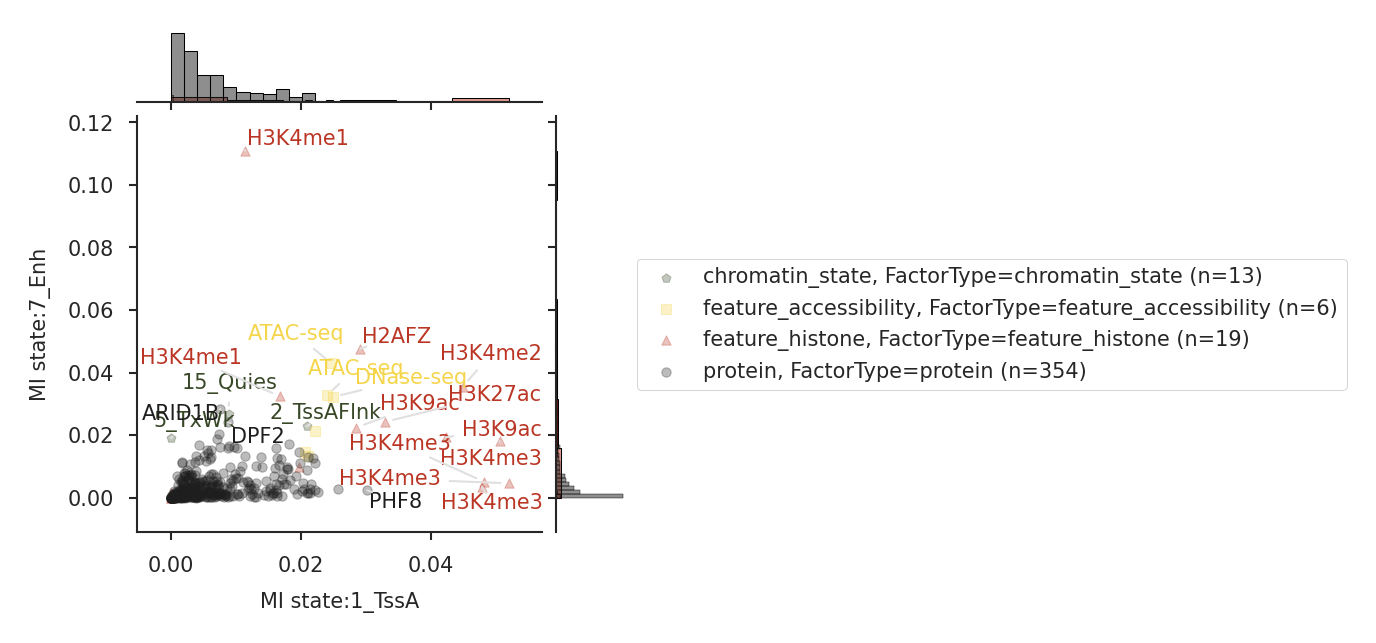

In [42]:
make_plot(
    x_col='mi_x', 
    y_col='mi_y', 
    xlabel=f'MI {x_col}',
    ylabel=f'MI {y_col}',
    df=df,#.query('FactorType == "protein"'), 
    hue_col='FactorType',
    shape_col='FactorType',
    shape_map=shape_map,
    hue_palette=hue_palette,
    annot_col='Factor',
    approx_number_of_labels=20,
    mean_line=False,
)

/home/ife/saulius.lukauskas/miniconda3/envs/marcs-chipseq-integration-bigwigs-data/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(<AxesSubplot:xlabel='Uncertainty coef (cols) state:1_TssA', ylabel='Uncertainty coef (cols) state:7_Enh'>,
 <AxesSubplot:ylabel='Count'>,
 <AxesSubplot:xlabel='Count'>)

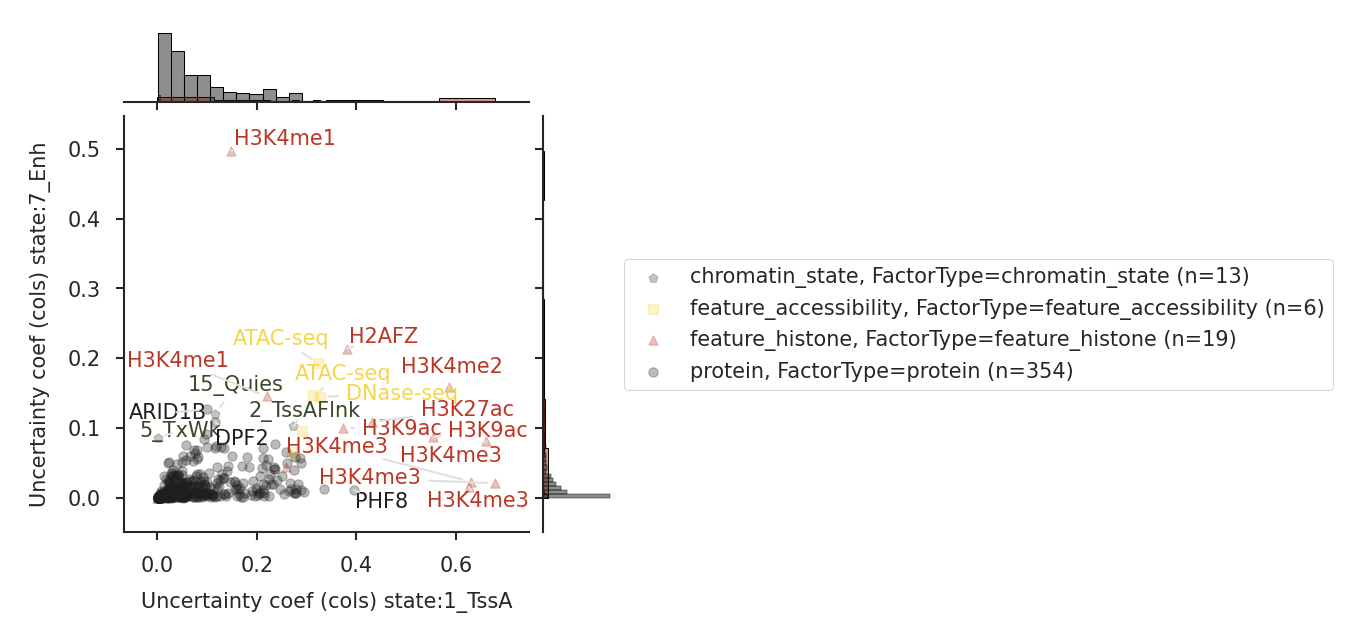

In [43]:
make_plot(
    x_col='uncertainty_coef_by_cols_x', 
    y_col='uncertainty_coef_by_cols_y', 
    xlabel=f'Uncertainty coef (cols) {x_col}',
    ylabel=f'Uncertainty coef (cols) {y_col}',
    df=df,#.query('FactorType == "protein"'), 
    hue_col='FactorType',
    shape_col='FactorType',
    shape_map=shape_map,
    hue_palette=hue_palette,
    annot_col='Factor',
    approx_number_of_labels=20,
    mean_line=False,
)

/home/ife/saulius.lukauskas/miniconda3/envs/marcs-chipseq-integration-bigwigs-data/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


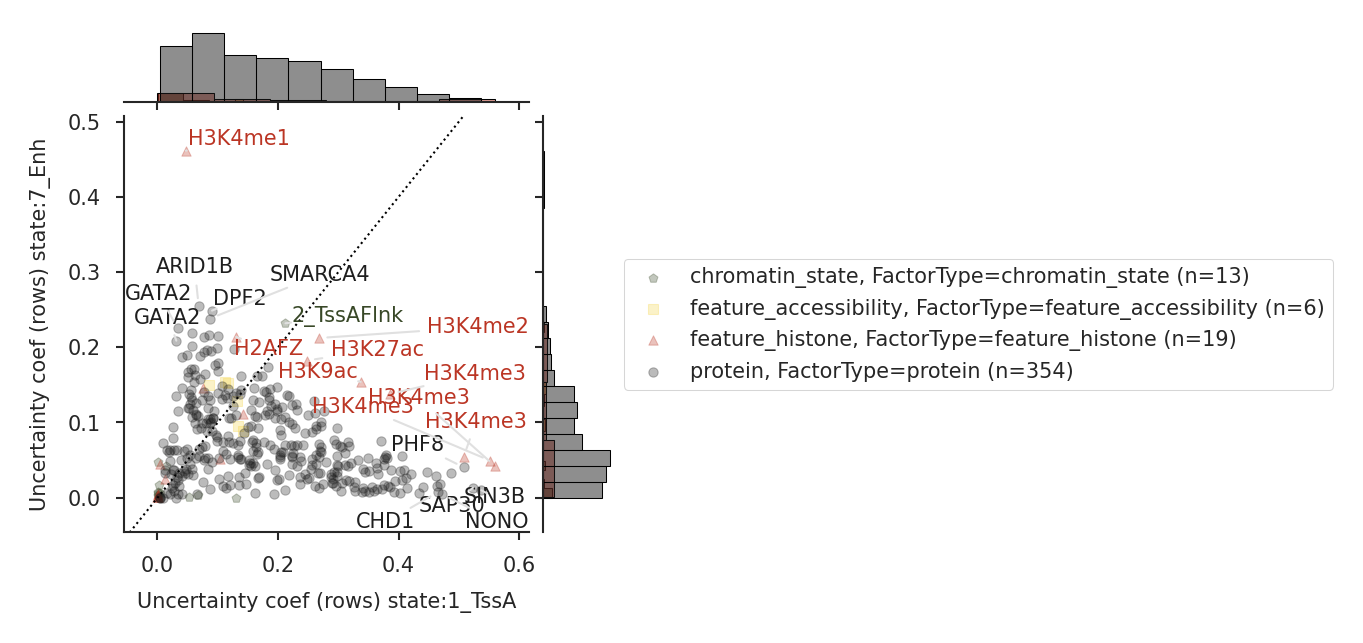

In [67]:
ax_joint, ax_marg_x, ax_marg_y = make_plot(
    x_col='uncertainty_coef_by_rows_x', 
    y_col='uncertainty_coef_by_rows_y', 
    xlabel=f'Uncertainty coef (rows) {x_col}',
    ylabel=f'Uncertainty coef (rows) {y_col}',
    df=df,#.query('FactorType == "protein"'), 
    hue_col='FactorType',
    shape_col='FactorType',
    shape_map=shape_map,
    hue_palette=hue_palette,
    annot_col='Factor',
    approx_number_of_labels=20,
    mean_line=False,
)

_xlim = ax_joint.get_xlim()
_ylim = ax_joint.get_ylim()

_from = np.max([np.min(_xlim), np.min(_ylim)])
_to = np.min([np.max(_xlim), np.max(_ylim)])

ax_joint.plot([_from, _to], [_from, _to], linestyle=':', color='k')

/home/ife/saulius.lukauskas/miniconda3/envs/marcs-chipseq-integration-bigwigs-data/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


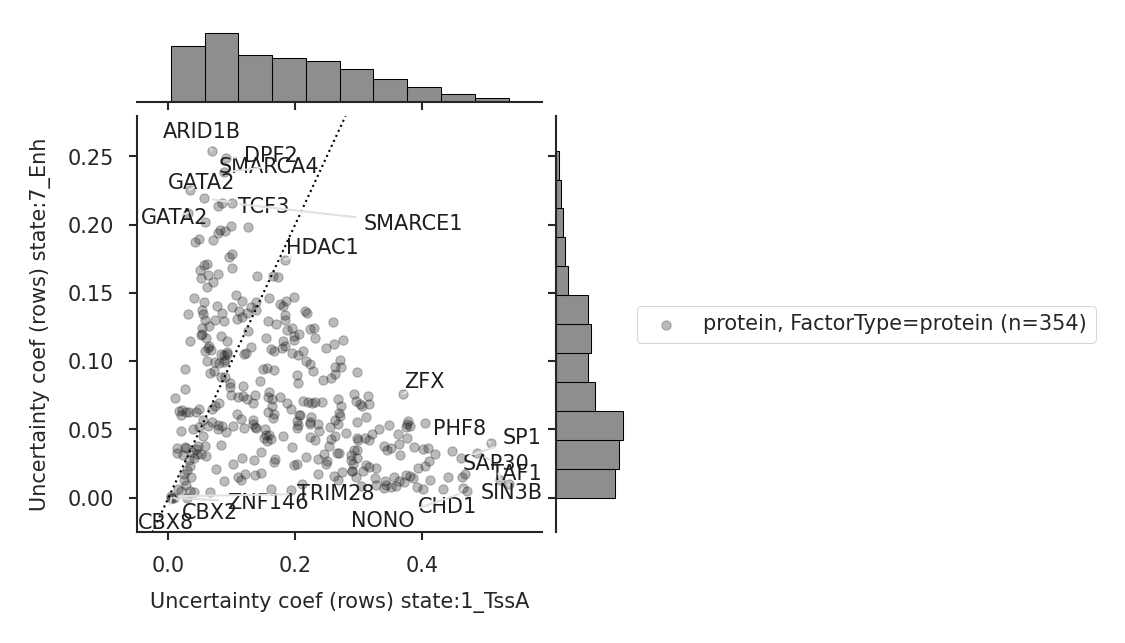

In [68]:
ax_joint, ax_marg_x, ax_marg_y = make_plot(
    x_col='uncertainty_coef_by_rows_x', 
    y_col='uncertainty_coef_by_rows_y', 
    xlabel=f'Uncertainty coef (rows) {x_col}',
    ylabel=f'Uncertainty coef (rows) {y_col}',
    df=df.query('FactorType == "protein"'), 
    hue_col='FactorType',
    shape_col='FactorType',
    shape_map=shape_map,
    hue_palette=hue_palette,
    annot_col='Factor',
    approx_number_of_labels=20,
    mean_line=False,
)

_xlim = ax_joint.get_xlim()
_ylim = ax_joint.get_ylim()

_from = np.max([np.min(_xlim), np.min(_ylim)])
_to = np.min([np.max(_xlim), np.max(_ylim)])

ax_joint.plot([_from, _to], [_from, _to], linestyle=':', color='k')

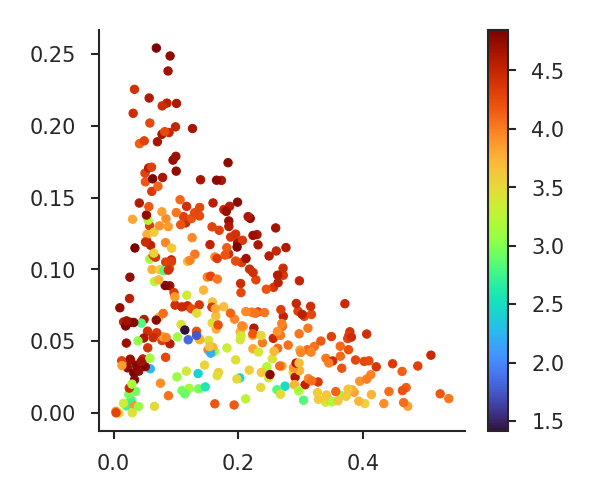

In [63]:
ax = plt.gca()

_prot_df = df.query('FactorType == "protein"')
                    
counts = ax.scatter(_prot_df['uncertainty_coef_by_rows_x'], _prot_df['uncertainty_coef_by_rows_y'], c=_prot_df['marginal_count_of_a'], cmap='turbo')
plt.colorbar(counts, ax=ax)

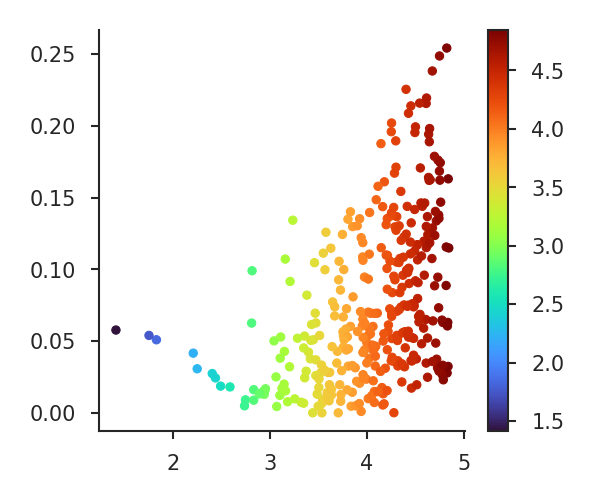

In [64]:
ax = plt.gca()

_prot_df = df.query('FactorType == "protein"')
                    
counts = ax.scatter(_prot_df['marginal_count_of_a'], _prot_df['uncertainty_coef_by_rows_y'], c=_prot_df['marginal_count_of_a'], cmap='turbo')
plt.colorbar(counts, ax=ax)

/home/ife/saulius.lukauskas/miniconda3/envs/marcs-chipseq-integration-bigwigs-data/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(<AxesSubplot:xlabel='Information quality ratio state:1_TssA', ylabel='Information quality ratio state:7_Enh'>,
 <AxesSubplot:ylabel='Count'>,
 <AxesSubplot:xlabel='Count'>)

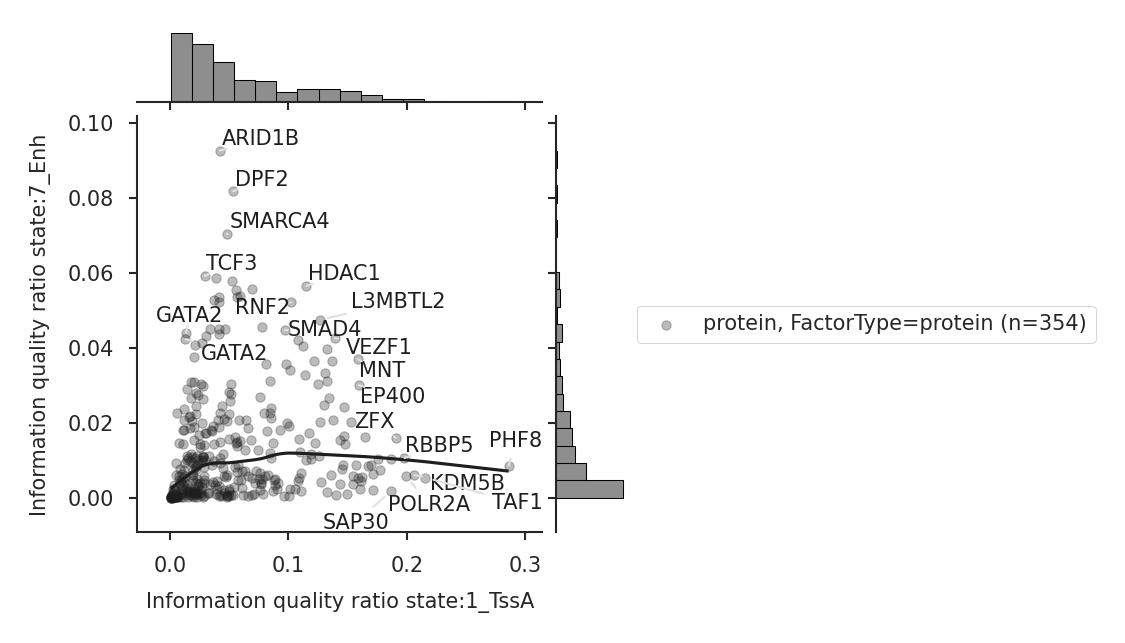

In [65]:
make_plot(
    x_col='information_quality_ratio_x', 
    y_col='information_quality_ratio_y', 
    xlabel=f'Information quality ratio {x_col}',
    ylabel=f'Information quality ratio {y_col}',
    df=df.query('FactorType == "protein"'), 
    hue_col='FactorType',
    shape_col='FactorType',
    shape_map=shape_map,
    hue_palette=hue_palette,
    annot_col='Factor',
    approx_number_of_labels=20,
)

In [37]:
store['/full/probabilities/joint/a:False_b:False']

b,dataset:ENCFF185XRG:max,dataset:ENCFF274YGF:max,dataset:ENCFF333TAT:max,dataset:ENCFF558BLC:max,dataset:ENCFF628UDH:max,dataset:ENCFF926HBH:max,dataset:ENCFF003LPE:max,dataset:ENCFF004HXL:max,dataset:ENCFF004YCK:max,dataset:ENCFF020XNM:max,dataset:ENCFF022KBK:max,dataset:ENCFF026BDA:max,dataset:ENCFF029RBI:max,dataset:ENCFF030AXK:max,dataset:ENCFF034SWM:max,dataset:ENCFF048BKZ:max,dataset:ENCFF053HPQ:max,dataset:ENCFF053PDX:max,dataset:ENCFF054XCG:max,dataset:ENCFF057JFH:max,dataset:ENCFF057NNR:max,dataset:ENCFF057RJK:max,dataset:ENCFF058ZHN:max,dataset:ENCFF060JVZ:max,dataset:ENCFF063NIH:max,dataset:ENCFF066OJB:max,dataset:ENCFF067FJF:max,dataset:ENCFF067KCK:max,dataset:ENCFF068IGH:max,dataset:ENCFF068MGV:max,dataset:ENCFF068OEJ:max,dataset:ENCFF070ZTX:max,dataset:ENCFF071GJH:max,dataset:ENCFF074OAM:max,dataset:ENCFF075OIT:max,dataset:ENCFF076GSK:max,dataset:ENCFF080IBW:max,dataset:ENCFF084KHS:max,dataset:ENCFF085GHX:max,dataset:ENCFF091TCH:max,dataset:ENCFF092DLN:max,dataset:ENCFF099OSI:max,dataset:ENCFF104VFF:max,dataset:ENCFF107DBQ:max,dataset:ENCFF107SJD:max,dataset:ENCFF113LBV:max,dataset:ENCFF114VAI:max,dataset:ENCFF117XRE:max,dataset:ENCFF118ATD:max,dataset:ENCFF118ECK:max,dataset:ENCFF119AHD:max,dataset:ENCFF124FTW:max,dataset:ENCFF130JVF:max,dataset:ENCFF136KLM:max,dataset:ENCFF137TCL:max,dataset:ENCFF139FMU:max,dataset:ENCFF142ZTD:max,dataset:ENCFF146GZZ:max,dataset:ENCFF148YMC:max,dataset:ENCFF150FJT:max,dataset:ENCFF151WYQ:max,dataset:ENCFF154IVU:max,dataset:ENCFF164CTH:max,dataset:ENCFF165ZEP:max,dataset:ENCFF167CQF:max,dataset:ENCFF169MAE:max,dataset:ENCFF171FVU:max,dataset:ENCFF171NEU:max,dataset:ENCFF171ZNN:max,dataset:ENCFF172CRL:max,dataset:ENCFF176MDV:max,dataset:ENCFF182MPT:max,dataset:ENCFF184IOY:max,dataset:ENCFF189OHQ:max,dataset:ENCFF190CGV:max,dataset:ENCFF192ASP:max,dataset:ENCFF193LLN:max,dataset:ENCFF195YGC:max,dataset:ENCFF199CQK:max,dataset:ENCFF199GFU:max,dataset:ENCFF201WFM:max,dataset:ENCFF206BGR:max,dataset:ENCFF209DVO:max,dataset:ENCFF209WPT:max,dataset:ENCFF211TTD:max,dataset:ENCFF215JWS:max,dataset:ENCFF217ACS:max,dataset:ENCFF217LXF:max,dataset:ENCFF217MBF:max,dataset:ENCFF219NIA:max,dataset:ENCFF221SKA:max,dataset:ENCFF224YBQ:max,dataset:ENCFF225GCF:max,dataset:ENCFF232ZHD:max,dataset:ENCFF242YZU:max,dataset:ENCFF245OJC:max,dataset:ENCFF256NXT:max,dataset:ENCFF257NOX:max,dataset:ENCFF258GDS:max,dataset:ENCFF258PLH:max,...,dataset:ENCFF804RVA:max,dataset:ENCFF807FNB:max,dataset:ENCFF813TRY:max,dataset:ENCFF816AEF:max,dataset:ENCFF820GPR:max,dataset:ENCFF821MKR:max,dataset:ENCFF821QOS:max,dataset:ENCFF821XJU:max,dataset:ENCFF822FKQ:max,dataset:ENCFF823RYG:max,dataset:ENCFF829FZW:max,dataset:ENCFF830MTX:max,dataset:ENCFF831NDQ:max,dataset:ENCFF835NOD:max,dataset:ENCFF835PDO:max,dataset:ENCFF836PGX:max,dataset:ENCFF837NNR:max,dataset:ENCFF838GFC:max,dataset:ENCFF842JME:max,dataset:ENCFF847QJI:max,dataset:ENCFF849VEO:max,dataset:ENCFF852ZIK:max,dataset:ENCFF854WAP:max,dataset:ENCFF864XZP:max,dataset:ENCFF866OZW:max,dataset:ENCFF873VFI:max,dataset:ENCFF877ZKU:max,dataset:ENCFF879NTL:max,dataset:ENCFF880BPX:max,dataset:ENCFF882ARK:max,dataset:ENCFF884MNF:max,dataset:ENCFF886UMM:max,dataset:ENCFF889QYR:max,dataset:ENCFF895RNS:max,dataset:ENCFF898CGY:max,dataset:ENCFF908MWB:max,dataset:ENCFF908SNB:max,dataset:ENCFF910JTR:max,dataset:ENCFF913WRW:max,dataset:ENCFF917RIN:max,dataset:ENCFF921FKB:max,dataset:ENCFF923GDR:max,dataset:ENCFF924FYI:max,dataset:ENCFF924GPK:max,dataset:ENCFF928BHE:max,dataset:ENCFF930WPG:max,dataset:ENCFF932FVX:max,dataset:ENCFF932KRN:max,dataset:ENCFF937QYU:max,dataset:ENCFF938ZPZ:max,dataset:ENCFF941EDY:max,dataset:ENCFF941SRW:max,dataset:ENCFF942VGF:max,dataset:ENCFF947AEO:max,dataset:ENCFF951BFN:max,dataset:ENCFF956MGE:max,dataset:ENCFF967URJ:max,dataset:ENCFF981ISM:max,dataset:ENCFF983LFS:max,dataset:ENCFF985QBS:max,dataset:ENCFF986BYT:max,dataset:ENCFF986SXD:max,dataset:ENCFF987DPX:max,dataset:ENCFF990SFN:max,dataset:ENCFF996OEL:max,dataset:ENCFF998LIR:max,dataset:EN

In [38]:
peaklist_matrix_indexed[peaklist_matrix_indexed['Factor'].str.contains('CBX')]

,peaklist_index,Identifier,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),Biosample term id,Biosample term name,Biosample type,Biosample organism,Biosample treatments,Biosample treatments amount,Biosample treatments duration,Biosample genetic modifications methods,Biosample genetic modifications categories,Biosample genetic modifications targets,Biosample genetic modifications gene targets,Biosample genetic modifications site coordinates,Biosample genetic modifications zygosity,Experiment target,Library made from,Library depleted in,Library extraction method,Library lysis method,Library crosslinking method,Library strand specific,Experiment date released,Project,RBNS protein concentration,Library fragmentation method,Library size range,Biological replicate(s),Technical replicate(s),Read length,Mapped read length,Run type,Paired end,Paired with,Index of,Derived from,Size,Lab,md5sum,dbxrefs,File download URL,Genome annotation,Platform,Controlled by,File Status,s3_uri,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR,Source,Factor,FactorType,Cell_full_type,Filename,marcs_gene_label
matrix_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
dataset:ENCFF066OJB:max,ENCFF066OJB,ENCFF066OJB,ENCFF066OJB,bed narrowPeak,bed,narrowPeak,IDR thresholded peaks,GRCh38,ENCSR272JAT,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBX5-human,DNA,NaN,NaN,NaN,NaN,NaN,2014-07-07,ENCODE,NaN,see document,NaN,"1, 2","1_1, 2_1",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF433VKM/, /files/ENCFF793EAF/, /fil...",124082,ENCODE Processing Pipeline,b736a8c8e31dac7cd0d1e46489b5356b,NaN,https://www.encodeproject.org/files/ENCFF066OJ...,NaN,NaN,NaN,released,s3://encode-public/2021/02/04/a8166fb9-6097-42...,ENCODE4 v1.6.1 GRCh38,released,"borderline replicate concordance, low read depth",NaN,NaN,encode,CBX5,protein,cell line|K562,output/interim/encode/downloaded_datasets/K562...,CBX5
dataset:ENCFF068OEJ:max,ENCFF068OEJ,ENCFF068OEJ,ENCFF068OEJ,bed narrowPeak,bed,narrowPeak,IDR thresholded peaks,GRCh38,ENCSR000ATV,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBX3-human,DNA,NaN,NaN,NaN,NaN,NaN,2012-08-06,ENCODE,NaN,see document,NaN,1,1_1,NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF420ARY/, /files/ENCFF226FKB/, /fil...",13671,ENCODE Processing Pipeline,1f7ce549f03d8503fbc0a290ef11124d,NaN,https://www.encodeproject.org/files/ENCFF068OE...,NaN,NaN,NaN,released,s3://encode-public/2020/12/27/14f61348-98d5-42...,ENCODE4 v1.6.1 GRCh38,released,"low read length, control low read depth, incon...",NaN,NaN,encode,CBX3,protein,cell line|K562,output/interim/encode/downloaded_datasets/K562...,CBX3
dataset:ENCFF258XBJ:max,ENCFF258XBJ,ENCFF258XBJ,ENCFF258XBJ,bed narrowPeak,bed,narrowPeak,IDR thresholded peaks,GRCh38,ENCSR000ATU,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBX2-human,DNA,NaN,NaN,NaN,NaN,NaN,2012-08-06,ENCODE,NaN,sonication (generic),200-600,1,1_1,NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF420ARY/, /files/ENCFF282PVX/, /fil...",52756,ENCODE Processing Pipeline,a37a1c34a0829adebe8032645b8986bd,NaN,https://www.encodeproject.org/files/ENCFF258XB...,NaN,NaN,NaN,released,s3://encode-public/2021/01/18/b140735d-7490-46...,ENCODE4 v1.6.1 GRCh38,released,"mild to moderate bottlenecking, low read lengt...","severe bottlenecking, insufficient read depth,...",NaN,encode,CBX2,protein,cell line|K562,output/interim/encode/downloaded_datasets/K562...,CBX2
dataset:ENCFF386ZWO:max,ENCFF386ZWO,ENCFF386ZWO,ENCFF386ZWO,bed narrowPeak,bed,narrowPeak,IDR thresholded peaks,GRCh38,ENCSR000BRT,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBX3-human,DNA,NaN,NaN,NaN,NaN,NaN,2012-02-29,ENCODE,NaN,see document,NaN,"1, 2

In [39]:
import itertools
def get_joint_table(store, a, b, what='probabilities', analysis_mode='full'):
    
    ans = pd.DataFrame(None, index=[False, True], columns=[False,True])
    ans.index.name = a
    ans.columns.name = b
    
    for b_a, b_b in itertools.product([False, True], repeat=2):
        ans.loc[b_a, b_b] = store[f'/{analysis_mode}/{what}/joint/a:{b_a}_b:{b_b}'].loc[a,b]
    
    return ans
        

In [40]:
get_joint_table(store, a='dataset:ENCFF486LNN:max', b='state:9_Rep', what='probabilities')

KeyError: 'dataset:ENCFF486LNN:max'

In [ ]:
get_joint_table(store, a='dataset:ENCFF477OUI:max', b='state:9_Het', what='counts')

In [ ]:
uncertainty_coef_by_rows['dataset:ENCFF486LNN:max'].sort_values(ascending=False).head(20)

In [ ]:
peaklist_matrix_indexed.loc[uncertainty_coef_by_rows['dataset:ENCFF486LNN:max'].sort_values(ascending=False).head(20).index]

In [ ]:
entropy.loc['dataset:ENCFF477OUI:max']

In [ ]:
entropy.loc['state:7_Enh']

In [ ]:
mi.loc['dataset:ENCFF477OUI:max', 'state:7_Enh']

In [ ]:
entropy.rank(pct=True).loc['dataset:ENCFF477OUI:max']

In [ ]:
entropy.rank(pct=True).loc['state:7_Enh']